# 0.0. IMPORTS

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
# change to project folder
%cd /content/drive/MyDrive/Colab Notebooks/Rossman Sales Prediction/

/content/drive/MyDrive/Colab Notebooks/Rossman Sales Prediction


In [20]:
!pip install inflection boruta

In [89]:
import pandas              as pd
import numpy               as np
import seaborn             as sb
import matplotlib.pyplot   as plt
import xgboost             as xgb

import inflection
import math
import datetime
import random
import pickle

from scipy                         import stats    as ss
from boruta                        import BorutaPy
from tabulate                      import tabulate

from sklearn.preprocessing         import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics               import mean_absolute_error, mean_squared_error
from sklearn.ensemble              import RandomForestRegressor
from sklearn.linear_model          import LinearRegression, Lasso

from IPython.display import Image
from IPython.display import HTML

## 0.1. Helper Functions

In [189]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed( range(1, kfold+1 ) ):

    if verbose:
      print( f'\nKFold Number: {k}' )

    # start and end date for validation 
    validation_start_date = x_training[ 'date' ].max() - datetime.timedelta( days=k*6*7 )
    validation_end_date = x_training[ 'date' ].max() - datetime.timedelta( days=(k-1)*6*7 )

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

    # training and validation dataset
    # training
    xtraining = training.drop( ['date', 'sales'], axis=1 )
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop( ['date', 'sales'], axis=1 )
    yvalidation = validation['sales']

    # model
    m = model.fit( xtraining, ytraining )

    # prediction
    yhat = m.predict( xvalidation )

    # performance
    model_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

    # store performance of each kfold iteration
    mae_list.append(  model_result['MAE']  )
    mape_list.append( model_result['MAPE'] )
    rmse_list.append( model_result['RMSE'] )

  return pd.DataFrame(  { 'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_absolute_percentage_error( y_pred, yhat ):
    return np.mean( np.abs( ( y_pred - yhat ) / y_pred ) )

def ml_error( model_name, y_pred, yhat ):
    mae = mean_absolute_error( y_pred, yhat )
    mape = mean_absolute_percentage_error( y_pred, yhat )
    rmse = np.sqrt( mean_squared_error( y_pred, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).to_numpy()
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    
    kcorr = k - ( k-1 )**2 / ( n-1 )
    rcorr = r - ( r-1 )**2 / ( n-1 )
    

    return np.sqrt( ( chi2corr/n ) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings():
  
    %matplotlib inline
    %pylab inline
  
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
  
    display( HTML( '<style>.container { width: 100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
  
    sb.set()

In [190]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Loading Data

In [24]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [25]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [26]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

new_columns = list( map(snakecase, old_columns) )

#rename
df1.columns = new_columns

## 1.2. Data Dimensions

In [27]:
print( f'Number of rows: {df1.shape[0]}')
print( f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [28]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

Verifica quais colunas possuem dados faltantes. Este passo é necessário para realizar algum tipo de tratamento em cima destas colunas.

In [29]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. FIllout NA

Existem várias abordagens para realizar o preenchimento de valores faltantes, mas neste projeto utilizei o método de preenchimento pensando no negócio. Não tenho expertise na área de vendas, portanto, nem todas substituições poderão ser a mais adequada.

In [30]:
# competition_distance
max_distance_value = 200000.0
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_distance_value if math.isnan(x) else x)

# competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


In [31]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [32]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

A descrição estatística é muito importante para ganhar conhecimento de negócio e conseguir identificar erros nos dados que estamos trabalhando.

In [33]:
# select numercial columns
num_attributes = df1.select_dtypes(include=['int64', 'float64', ])

# select categorical columns
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [34]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
metrics = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [35]:
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2. Categorical Attributes

In [36]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

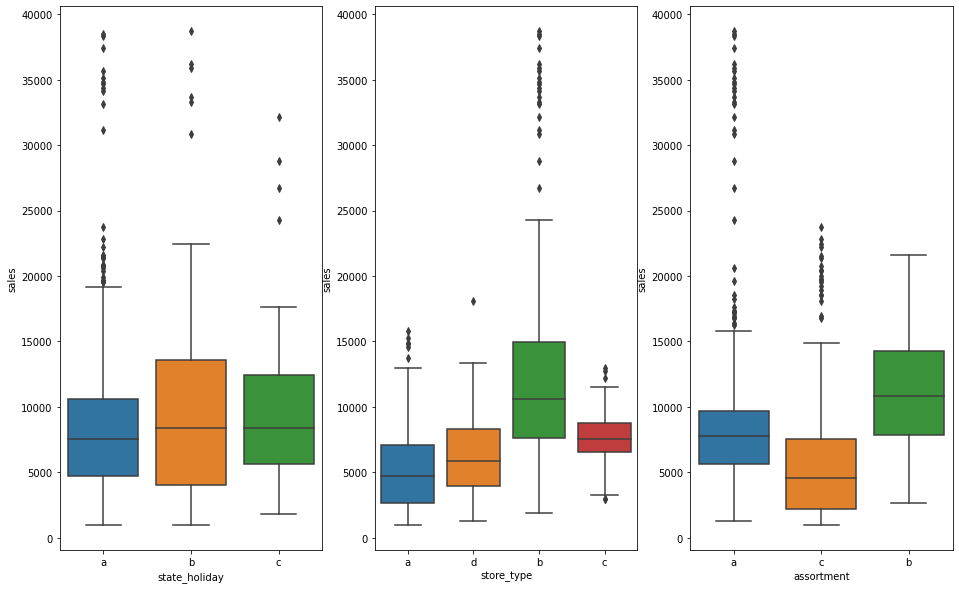

In [37]:
# filter only important datas
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.figure( figsize=( 16, 10 ) )
plt.subplot( 1, 3, 1)
sb.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2)
sb.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3)
sb.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. FEATURE ENGINEERING

In [38]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

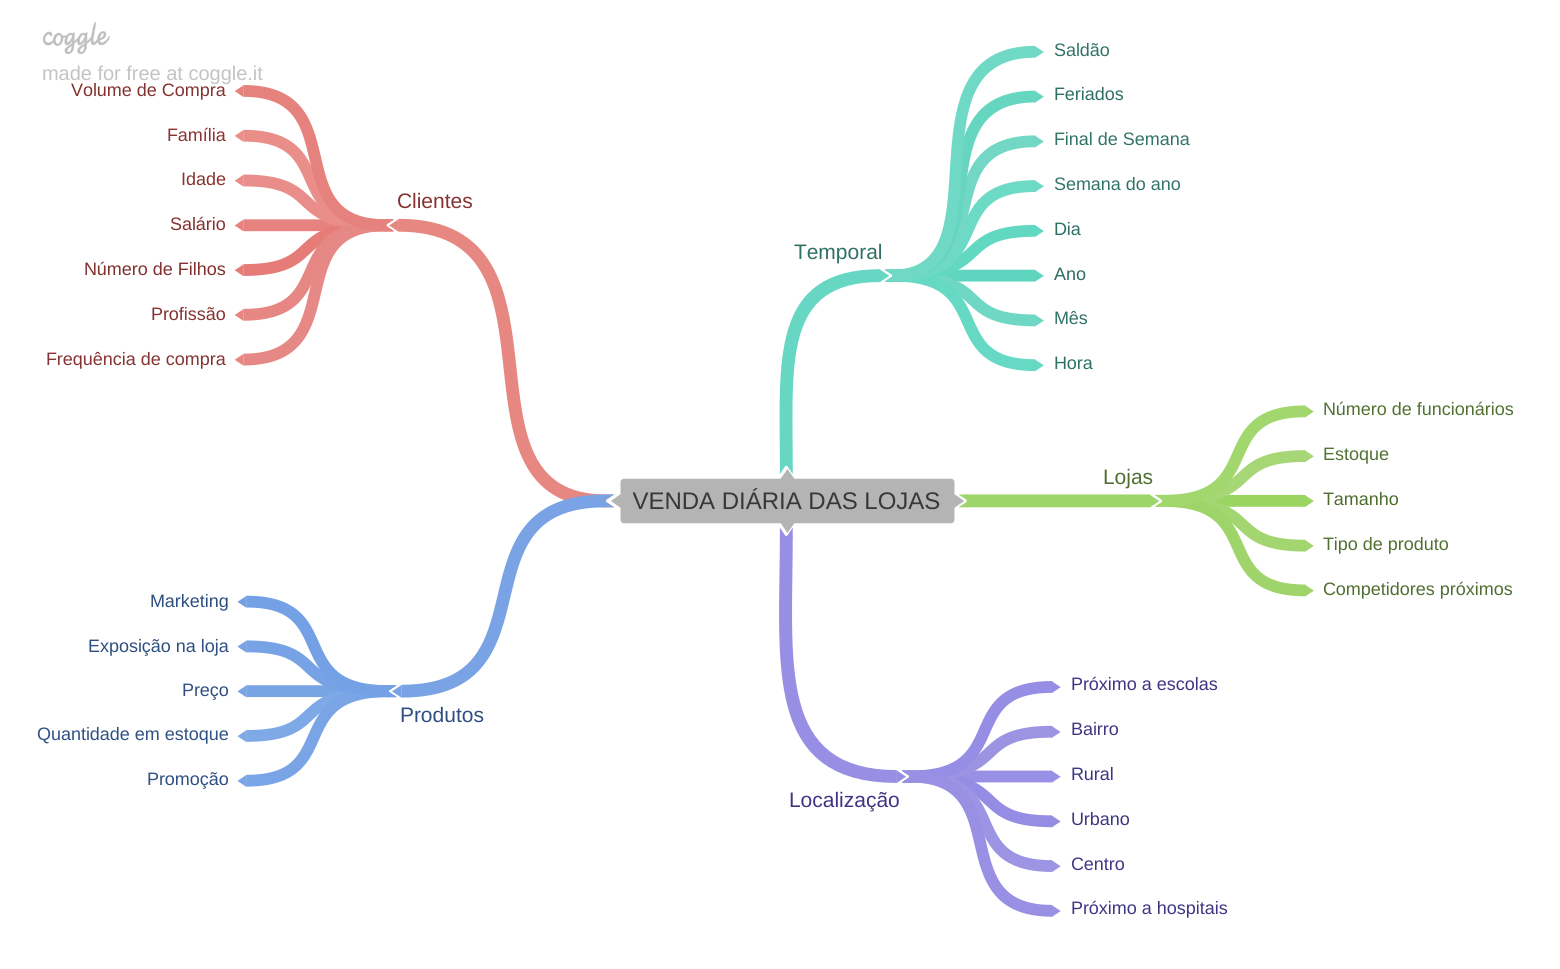

In [39]:
Image('img/mind_map_hypothesis.png')

### 2.1.1. Lojas Hypothesis

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento de produtos deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Produto Hypothesis

**8.** Lojas que investem mais em marketing deveriam vender mais.

**9.** Lojas que expõe mais o produtos nas vitrines deveriam vender mais.

**10.** Lojas que tem preço menores nos produtos deveriam vender mais.

**11.** Lojas que tem produtos com preço menores por mais tempo deveriam vender mais.

**12.** Lojas com promoções mais "agressivas" deveriam vender mais.

**13.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**14.** Lojas com mais dias de promoção deveriam vender mais.

**15.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Temporal Hypothesis

**16.** Lojas que abrem durante o feriado de Natal deveriam vender mais.

**17.** Lojas deveriam vender menos aos finais de semana.

**18.** Lojas deveriam vender mais ao longo dos anos.

**19.** Lojas deveriam vender mais no segundo semestre do ano.

**20.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**21.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Final Hypothesis List

Hipóteses que são possíveis de serem respondidas com base no conjunto de dados disponível. Em um ambiente real, as informações faltantes seriam solicitadas ao time de engenharia de dados para disponibilizarem algumas variáveis importantes para responder as demais hipóteses.

**5.** Lojas com maior sortimento de produtos deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.

**13.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**14.** Lojas com mais dias de promoção deveriam vender mais.

**15.** Lojas com mais promoções consecutivas deveriam vender mais.

**16.** Lojas que abrem durante o feriado de Natal deveriam vender mais.

**17.** Lojas deveriam vender menos aos finais de semana.

**18.** Lojas deveriam vender mais ao longo dos anos.

**19.** Lojas deveriam vender mais no segundo semestre do ano.

**20.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**21.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [40]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/ 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if  x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if  x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


# 3.0. FILTERING VARIABLES

In [41]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [42]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2 Columns Selection

In [43]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. EXPLORATORY DATA ANALYSIS

In [44]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

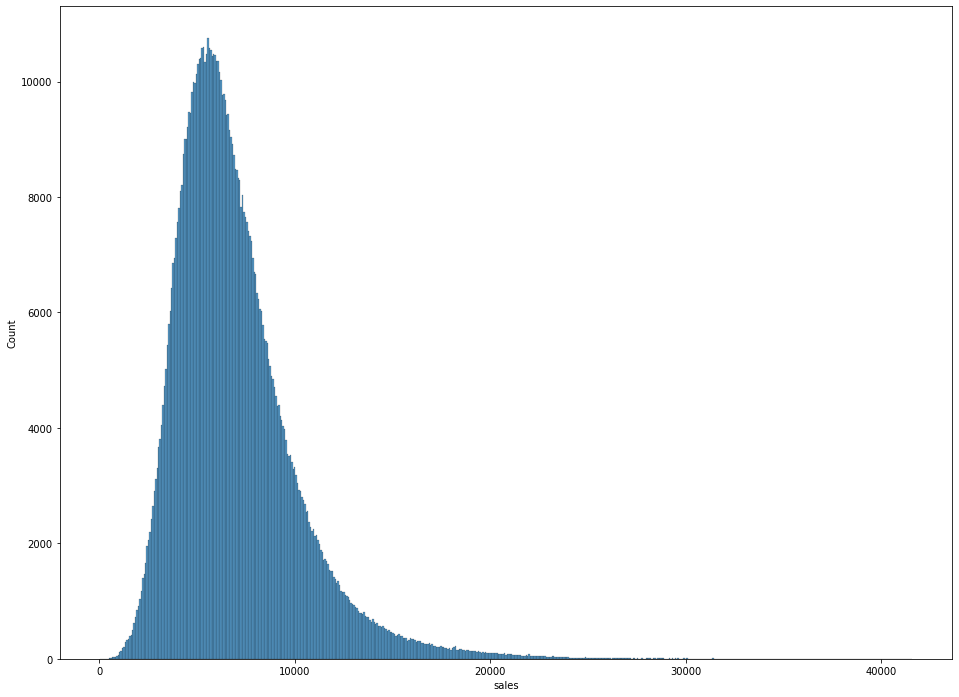

In [45]:
plt.rcParams['figure.figsize'] = [16, 12]
sb.histplot( df4['sales'] );

### 4.1.2. Numerical Variable

Analisando o gráfico abaixo das variáveis númericas, pode-se perceber que, a feature **day_of_week** não possui variações, ou seja, as lojas venderam basicamente a mesma quantidade durante cada dia da semana, portanto, esta feature não será relevante para o modelo. Outras features apresentaram informações importantes para o negócio, como a **is_promo** na qual, percebe-se que houve mais vendas de produtos que não estavam em promoção, o que pode ser um insight para o time de negócio.

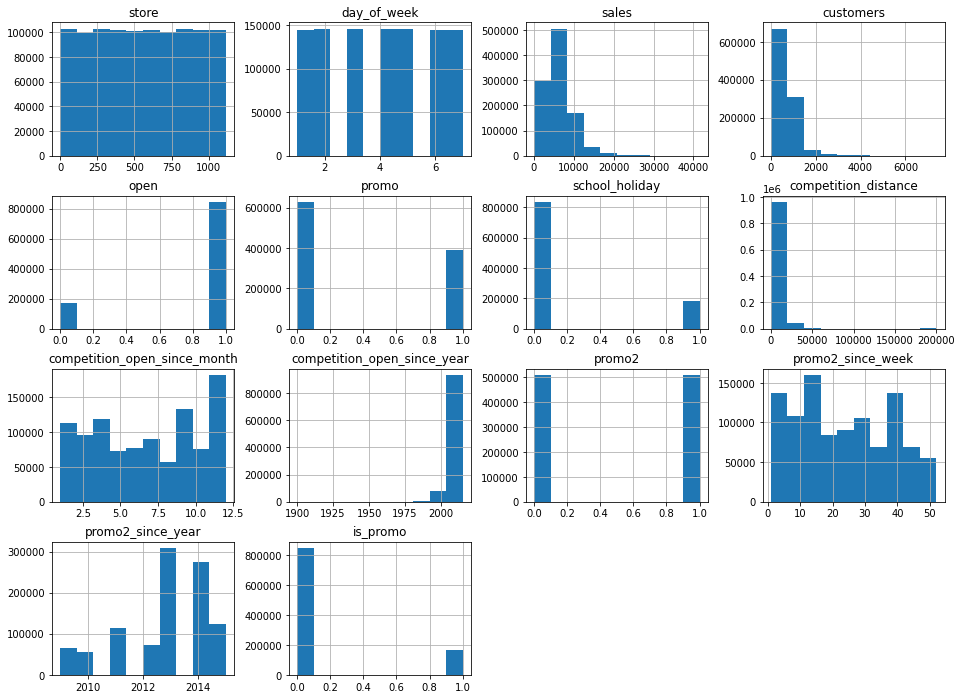

In [46]:
num_attributes.hist();

### 4.1.3. Categorical Variable

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


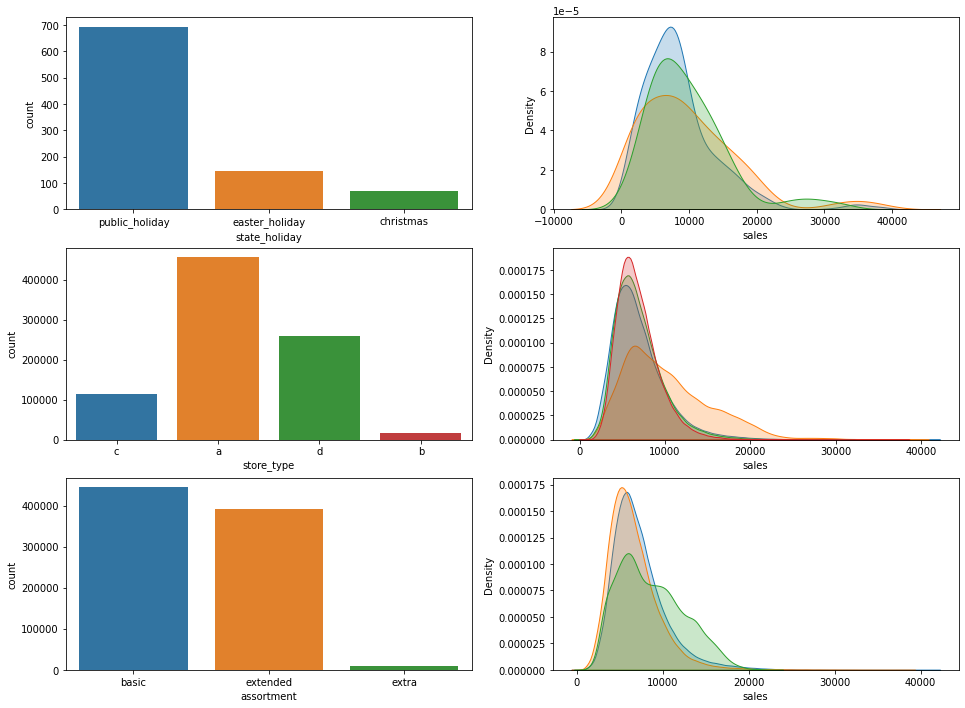

In [47]:
# state_holiday
plt.subplot( 3, 2, 1 )
aux1 = df4[df4['state_holiday'] != 'regular_day']
sb.countplot( aux1['state_holiday'] )

plt.subplot( 3, 2, 2 )
sb.kdeplot( data=df4[df4['state_holiday'] == 'public_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade=True );
sb.kdeplot( data=df4[df4['state_holiday'] == 'christmas']['sales'], shade=True );

# store_type
plt.subplot( 3, 2, 3 )
sb.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sb.kdeplot( data=df4[df4['store_type'] == 'a']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'b']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'c']['sales'], shade=True );
sb.kdeplot( data=df4[df4['store_type'] == 'd']['sales'], shade=True );

# assortment
plt.subplot( 3, 2, 5 )
sb.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sb.kdeplot( data=df4[df4['assortment'] == 'extended']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'basic']['sales'], shade=True );
sb.kdeplot( data=df4[df4['assortment'] == 'extra']['sales'], shade=True );

## 4.2. Bivariate Analysis

### **H5.** Lojas com maior sortimento de produtos deveriam vender mais.

**Falso**. De acordo com o gráfico abaixo, percebe-se que as lojas que possuem mais sortimento são as que vendem menos.

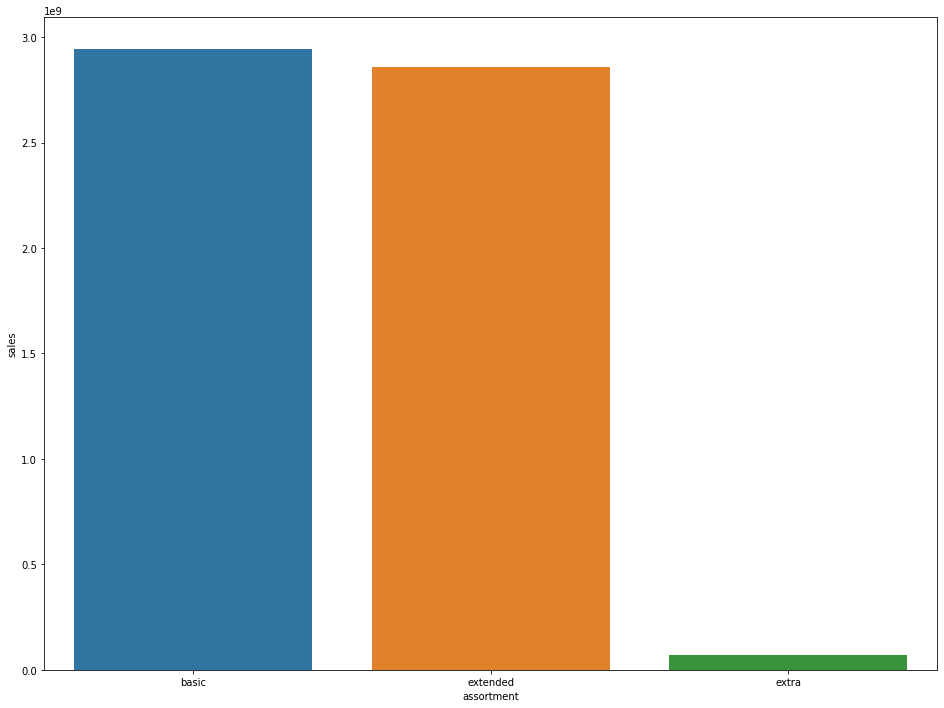

In [48]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sb.barplot( x='assortment', y='sales', data=aux1 );

Para fazer uma inspeção mais aprofundada desta hipótese, deseja-se inicialmente descobrir se as lojas com maior sortimento vendiam mais no passado do que atualmente. Mas, analisando o segundo gráfico temporal, percebe-se que o sortimento **extra** oscilou bastante durante o tempo, o que não era possível de ser identificado no primeiro gráfico. Analisando o primeiro gráfico, percebeu-se que os sortimentos **basic** e **extended** são muito similares, mas que visualizando o conjunto das 3 variáveis, elas serão relevantes para o modelo.

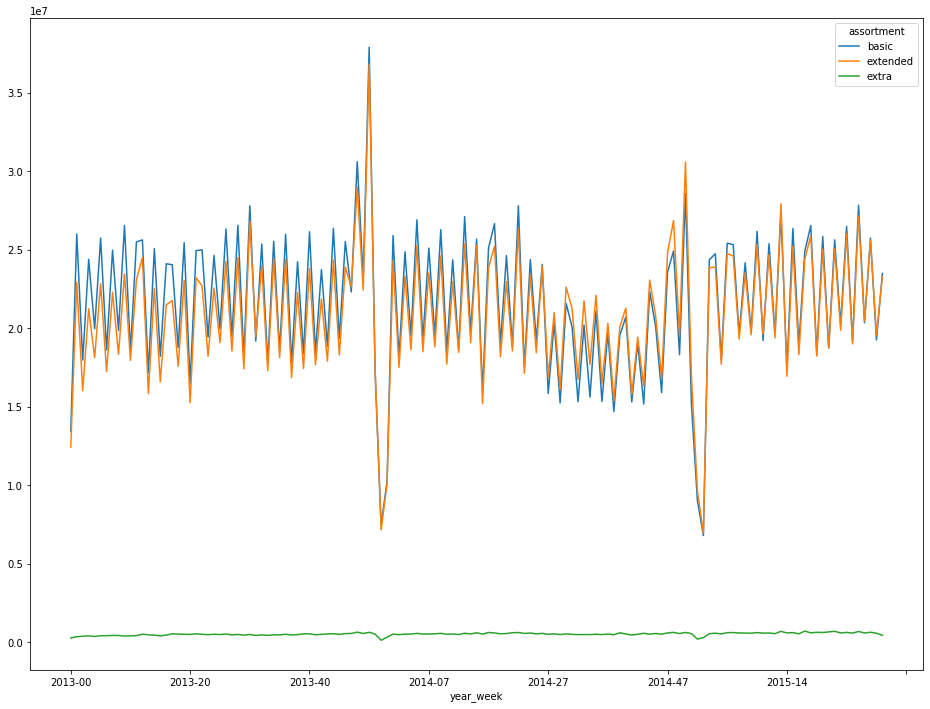

In [49]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

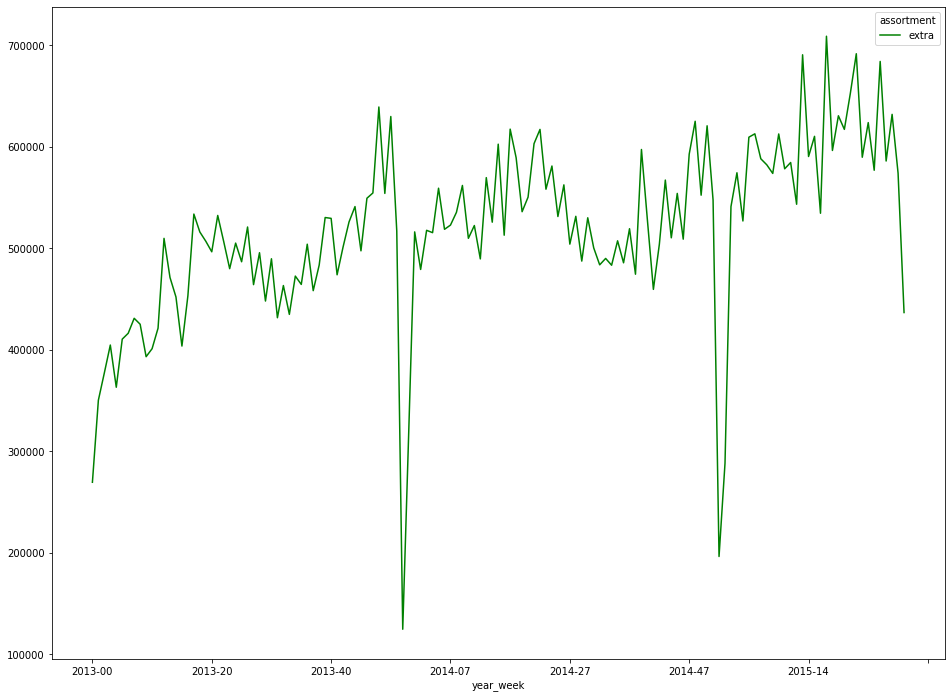

In [50]:
aux3 = df4[df4['assortment'] == 'extra']
aux3 = aux3[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot(color='green');

### **H6.** Lojas com competidores mais próximos deveriam vender menos.

**Falso**. Analisando os gráficos abaixo, percebe-se que as lojas que possuem competidores próximos vendem mais que as lojas que possuem competidores mais distantes. Oque é realmente intrigante, fugindo um pouco do censo comum de que "quanto maior a concorrência menor é a venda". Muito provável que este seja um insight relevante para o negócio.

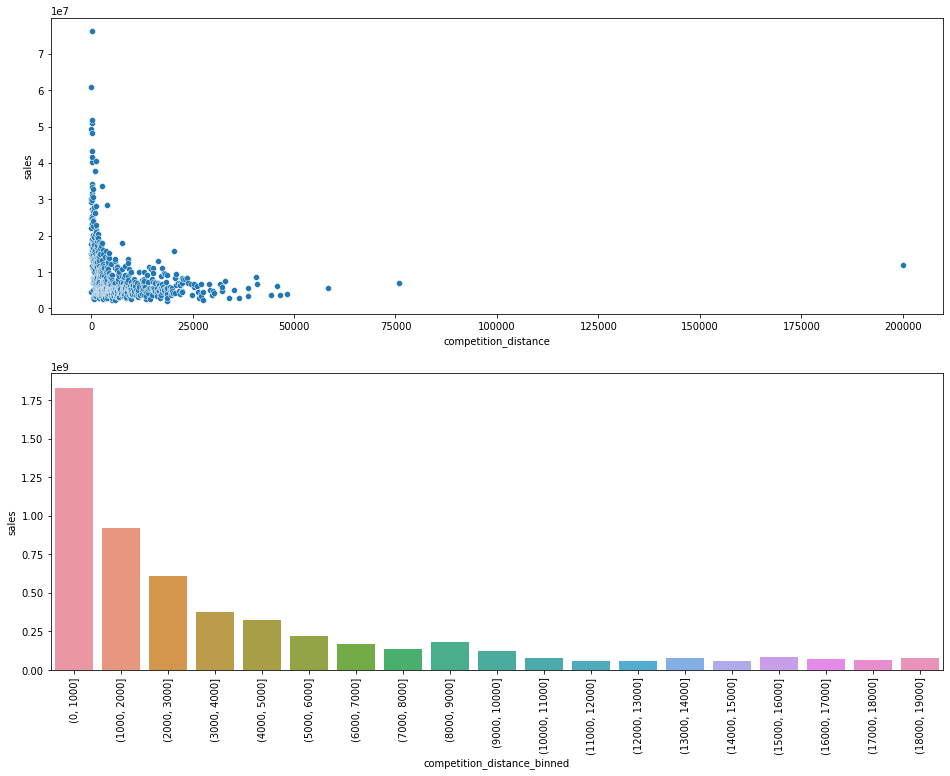

In [51]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# agroup competition distance
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()

# scatter plot
plt.subplot(2, 1, 1)
sb.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot(2, 1, 2)
plt.xticks(rotation=90)
sb.barplot( x='competition_distance_binned', y='sales', data=aux2 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma certa correlação com as vendas.

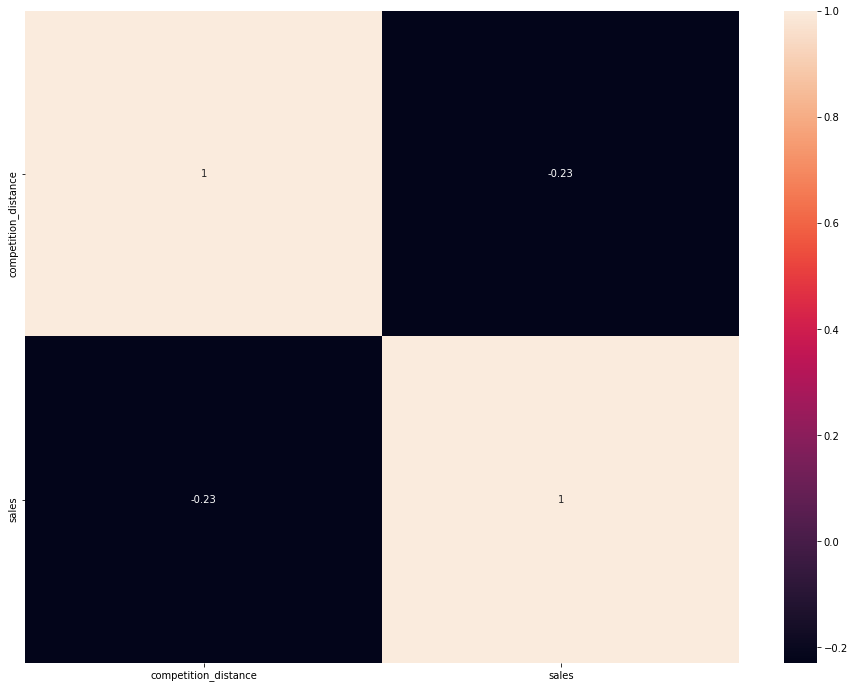

In [52]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Lojas com competidores à mais tempo deveriam vender mais.

**Falso**. Analisando o gráfico abaixo, percebe-se que quanto mais recente é a concorrência, maior é o número de vendas, oque também é bastante intrigante. Portanto, lojas com competidores à mais tempo vendem menos.

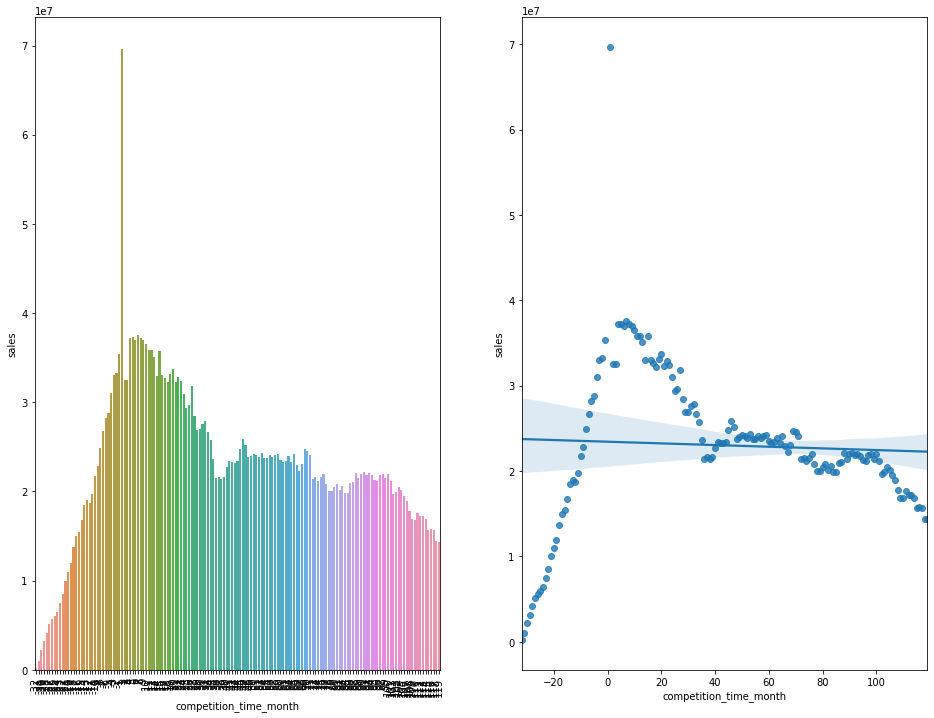

In [53]:
plt.subplot( 1 , 2, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
plt.xticks(rotation=90)
sb.barplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 2, 2 )
sb.regplot( x='competition_time_month', y='sales', data=aux2 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação fraca com as vendas.

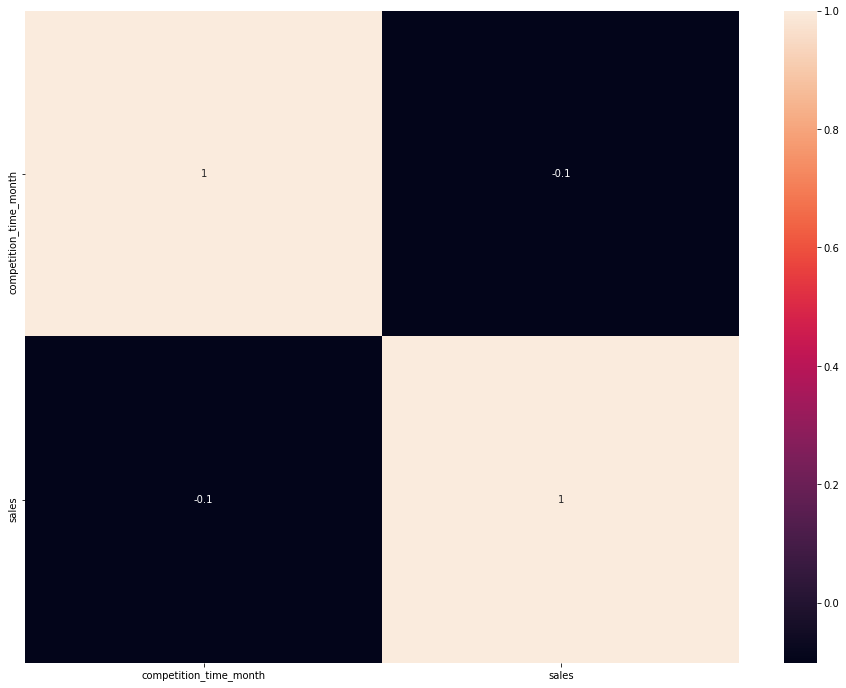

In [54]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Falso.** Analisando os gráficos abaixo percebe-se que para os valores onde o valor de promo_time_week é positivo, significa que as vendas foram realizadas no período de promoção extendida, e caso seja negativa é onde as vendas foram no período de promoção regular. Portanto, analisando o primeiro gráfico percebe-se que as promoções ativas por mais tempo vendem regularmente, e não só isto, ao passar do tempo ela tem uma tendência de decaimento, que pode ser comprovado pelo gráfico de tendência ao lado, significando que o efeito da promoção tem um certo período de eficácia. 

Já as vendas no período regular tendem a crescer ao longo do tempo, isto pode ser fruto do trabalho da área de marketing, na qual, as pessoas são informadas de que a loja está em período promocional resultando em mais vendas. 

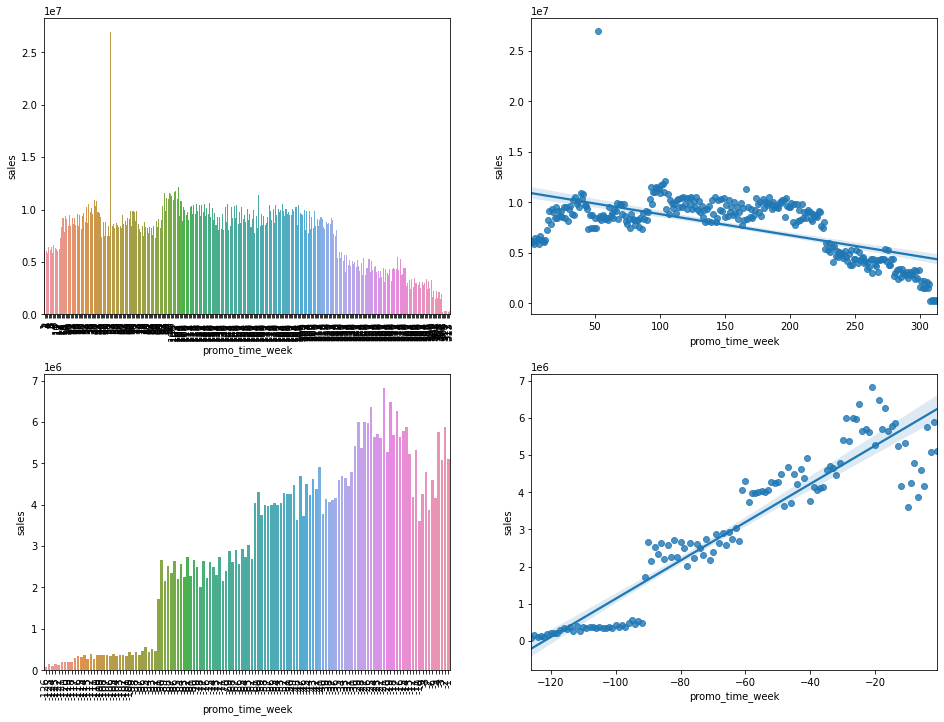

In [55]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# extended promo
plt.subplot(2, 2, 1)
plt.xticks( rotation=90 )
aux2 = aux1[aux1['promo_time_week'] > 0 ]
sb.barplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot(2, 2, 2)
sb.regplot( x='promo_time_week', y='sales', data=aux2 );

# regular promo
plt.subplot(2, 2, 3)
plt.xticks( rotation=90 )
aux3 = aux1[aux1['promo_time_week'] < 0 ]
sb.barplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot(2, 2, 4)
sb.regplot( x='promo_time_week', y='sales', data=aux3 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação fraca com as vendas.

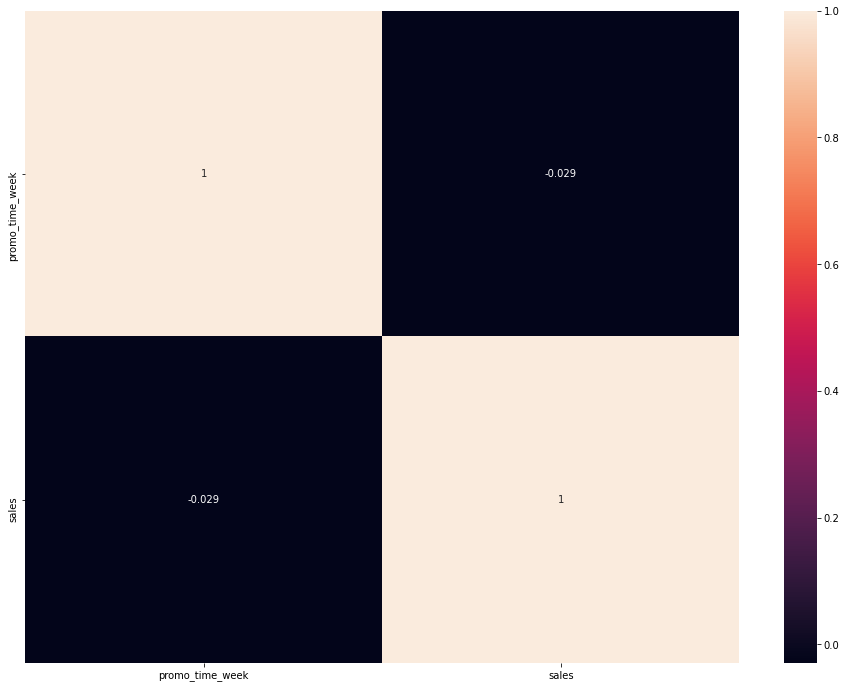

In [56]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s>**H14.** Lojas com mais dias de promoção deveriam vender mais.</s> ( *Motivo: Muito similar a Hipótese 13, sendo necessário a criação de uma variável promo_days para ser validada, deixaremos para o próximo ciclo do CRISP-DM)

### **H15.** Lojas com mais promoções consecutivas deveriam vender mais.

**Falso.** Analisando a tabela abaixo, percebe-se que as lojas que participaram apenas da promoção regular **promo** venderam mais que as lojas que participaram da promoção extendida **promo2**. Uma informação interessante é que as lojas que não participaram de nenhuma promoção, venderam mais que as lojas que participaram das duas promoções simultaneamente, na qual, estas lojas também possuíam uma frequência de vendas maior.

In [57]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index().sort_values( by='sales' )

,promo,promo2,sales
1,0,1,1289362241
3,1,1,1472275754
0,0,0,1482612096
2,1,0,1628930532


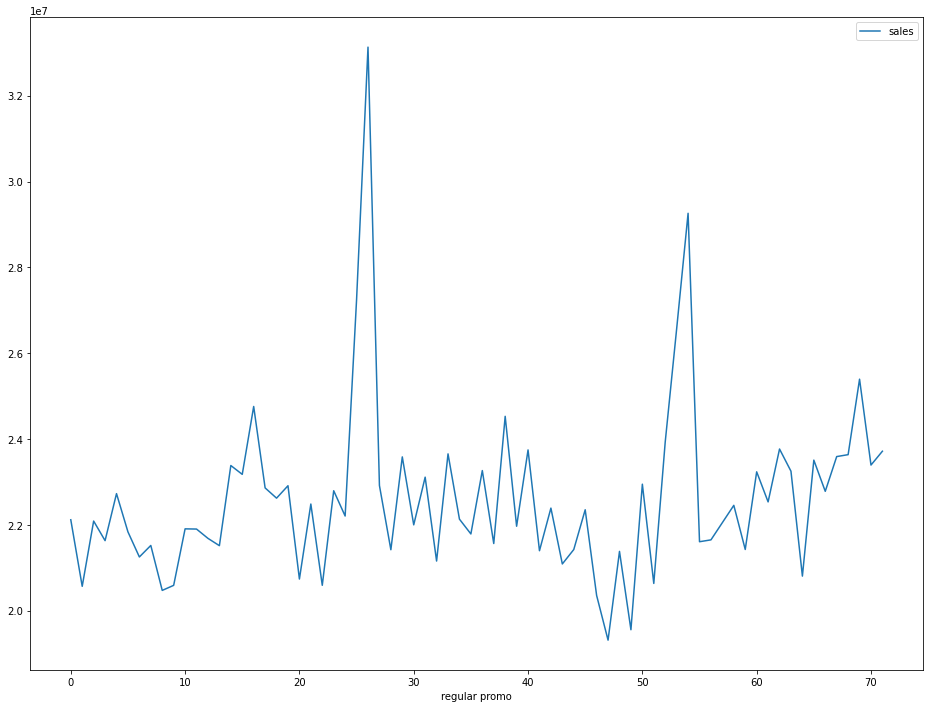

In [58]:
# regular promo
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux1.plot();
plt.xlabel('regular promo');

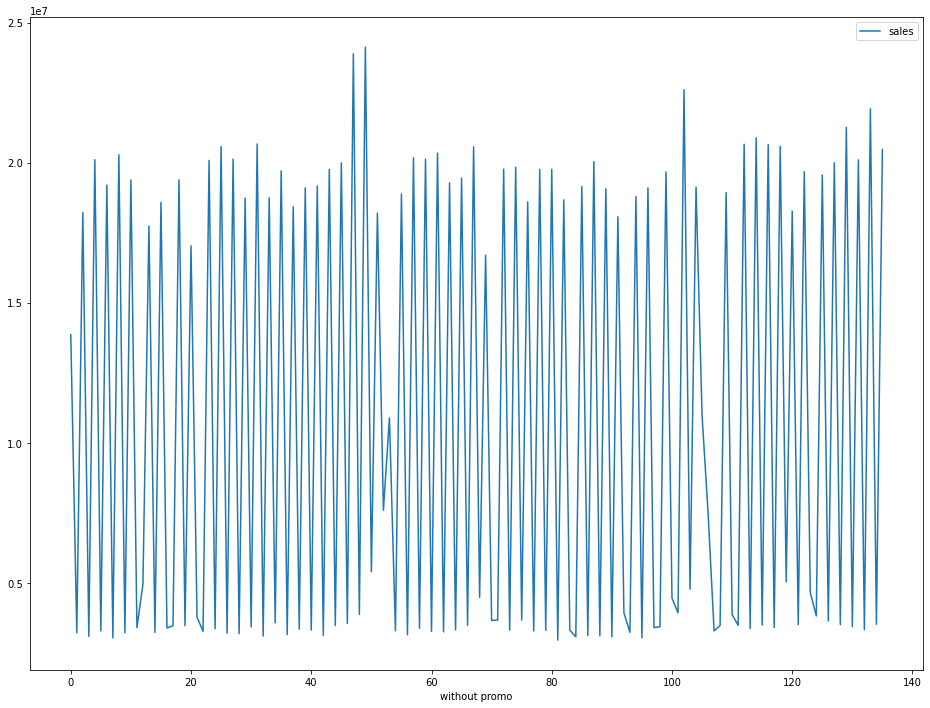

In [59]:
# without promo
aux2 = df4[( df4['promo'] == 0 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot();
plt.xlabel('without promo');

### **H16.** Lojas que abrem durante o feriado de Natal deveriam vender mais.

**Falso.**. Analisando os gráficos abaixo, é possível notar que lojas abertas durante o feriado de Natal vendem menos. As vendas estão concentradas nos feriados públicos, e não em datas especiais como Natal e Páscoa.

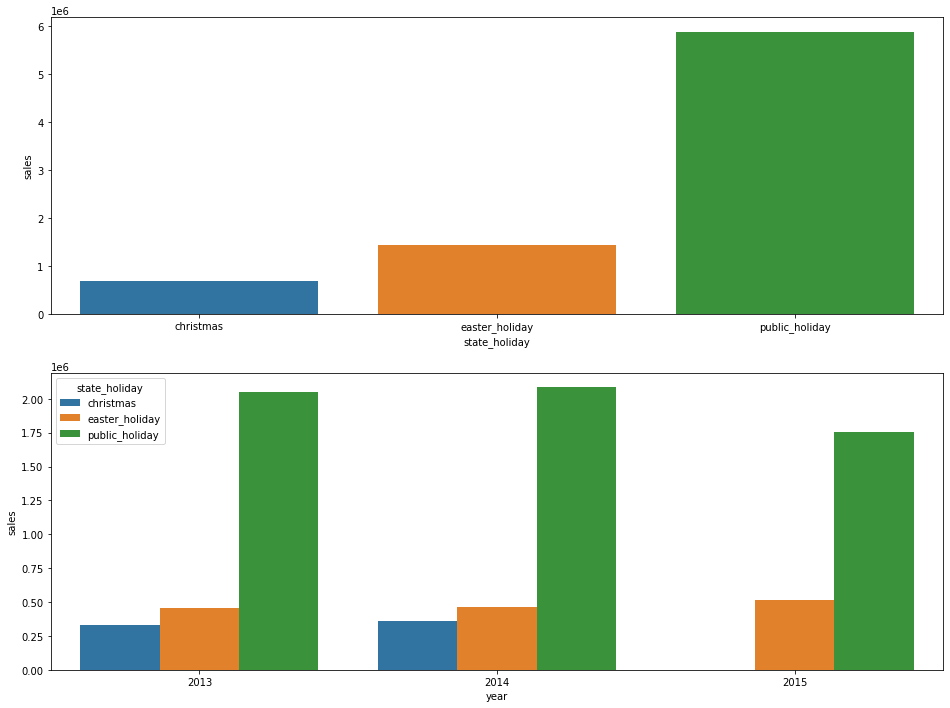

In [60]:
aux1 = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(2, 1, 1)
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sb.barplot( x='state_holiday', y='sales', data=aux2 );

plt.subplot(2, 1, 2)
aux3 = aux1[['year', 'state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sb.barplot( x='year', y='sales', hue='state_holiday',data=aux3 );

### **H17.** Lojas deveriam vender menos aos finais de semana.

**Verdadeiro.** Analisando os gráficos abaixo, percebe-se que o volume de vendas é maior durante os dias da semana. Portanto, nos dias 6 (sábado) e 7 (domingo) são os dias que as lojas vendem menos.

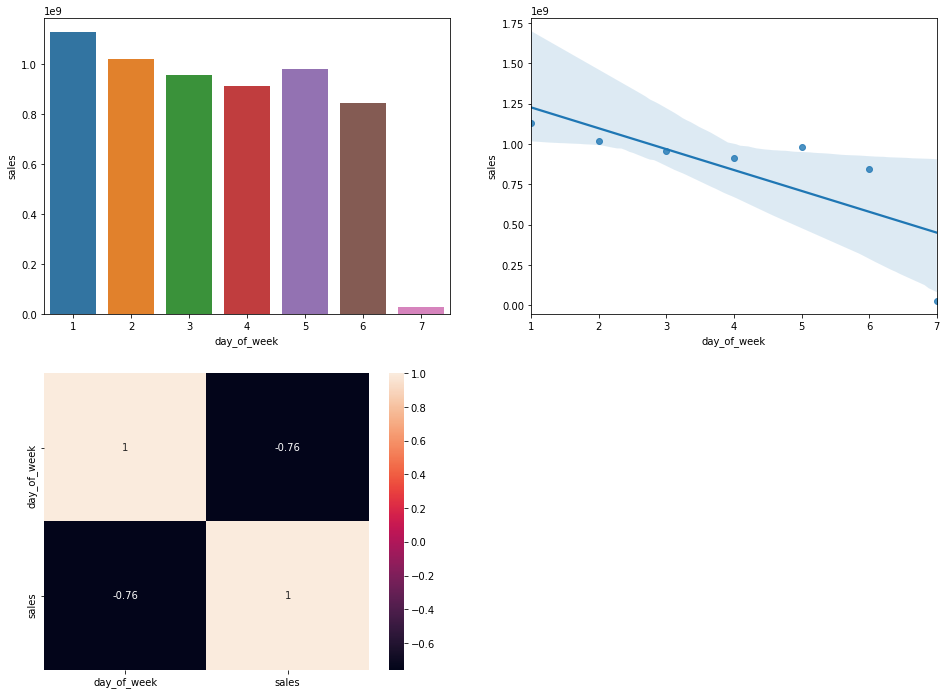

In [61]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sb.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 2)
sb.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 2, 2, 3)
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H18.** Lojas deveriam vender mais ao longo dos anos.

**Falso.** Analisando os gráficos percebe-se que ao passar dos anos, as vendas sofrem um decaimento, e não uma crescente. Portanto, as lojas vendem menos ao longo dos anos.

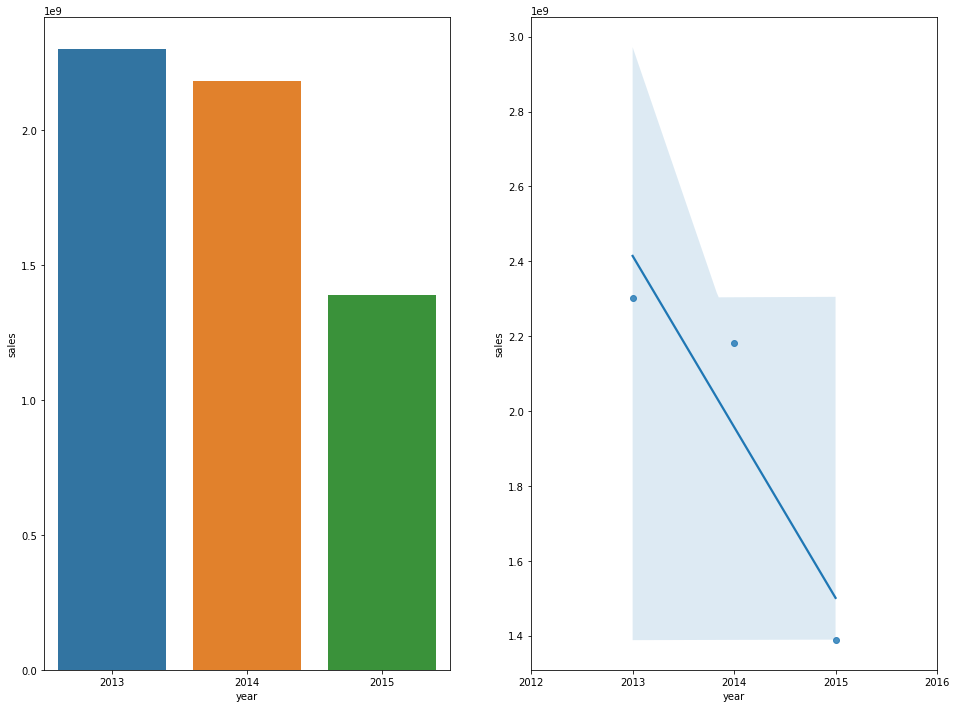

In [62]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sb.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
sb.regplot( x='year', y='sales', data=aux1 );
plt.xticks([2012, 2013, 2014, 2015, 2016]);

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação muito forte negativamente com as vendas. Ou seja conforte os anos vão aumentando as vendas vão caindo, porém, isto deve-se pelo motivo de que esta base não tem os dados completos de 2015 que ainda estavam em andamento.

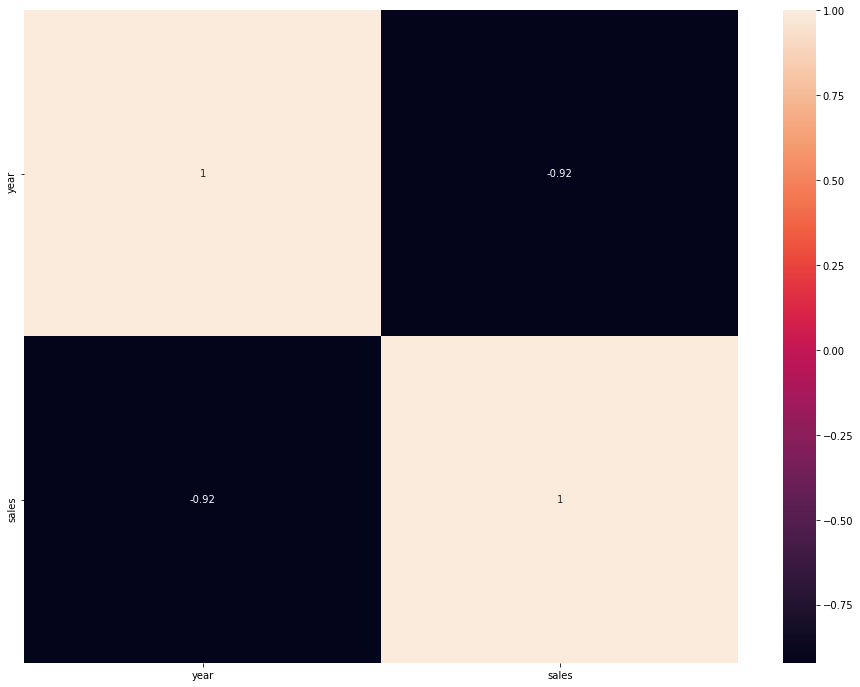

In [63]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H19.** Lojas deveriam vender mais no segundo semestre do ano.

**Falso.** Analisando os gráficos percebe-se que no segundo semestre do ano, as lojas vendem menos. Ou seja no segundo semestre do ano, as vendas da Rossmann cai consideravelmente, indicando que esta empresa concentra seus principais ganhos no início do semestre.

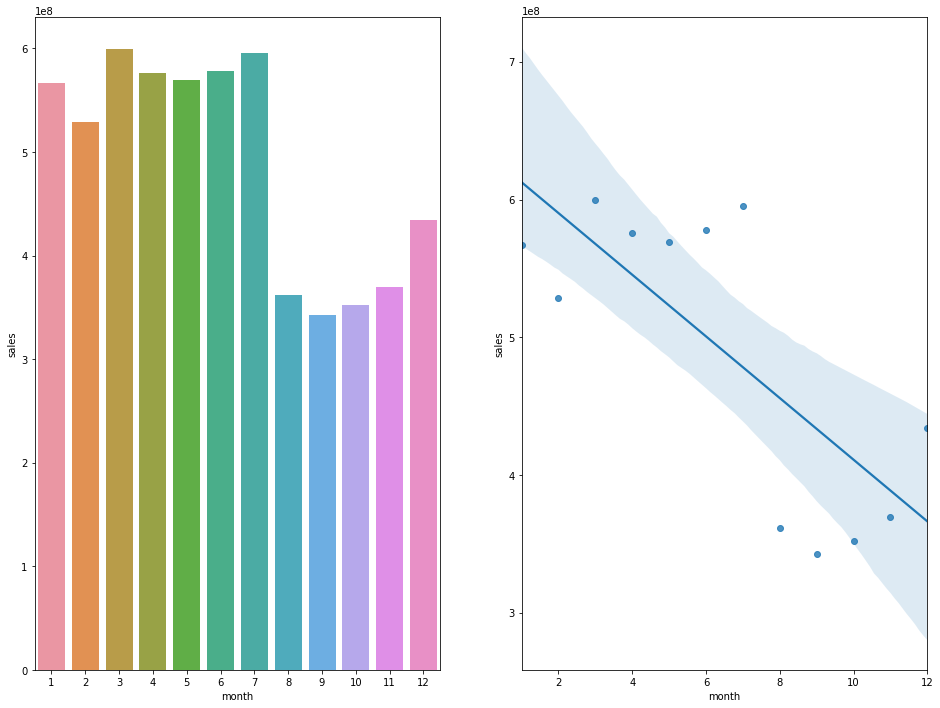

In [64]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 2, 1)
sb.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 2, 2)
sb.regplot( x='month', y='sales', data=aux1 );

Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação bem forte negativamente com as vendas.

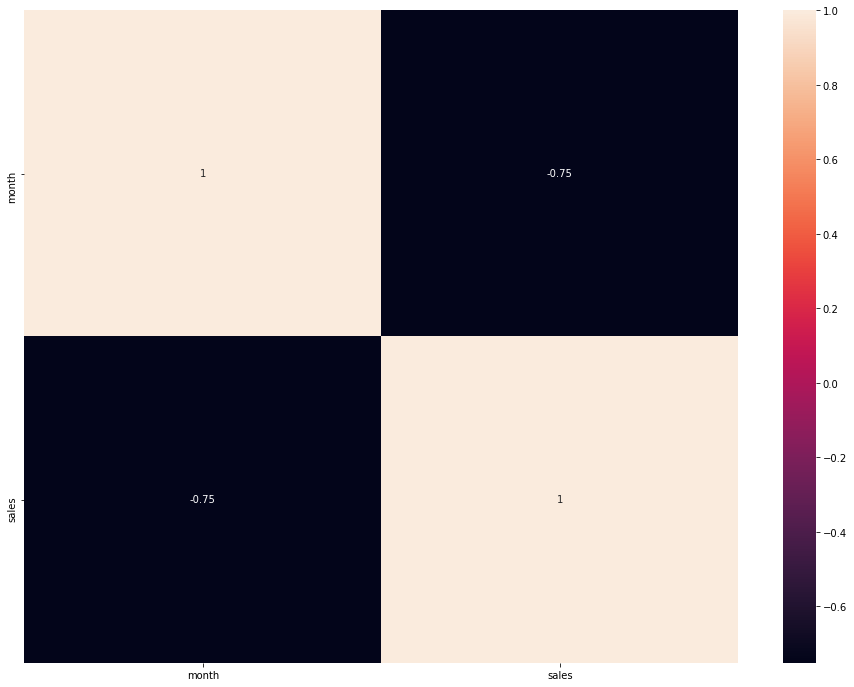

In [65]:
sb.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H20.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**Verdadeiro.** Analisando os gráficos abaixo percebe-se que as lojas efetuam mais vendas depois do dia 10 de cada mês.


Para inferir a correlação da feature com a variável resposta utilizou-se um heatmap. Na qual, percebe-se que esta variável sozinha possui uma correlação razoável negativamente com as vendas.

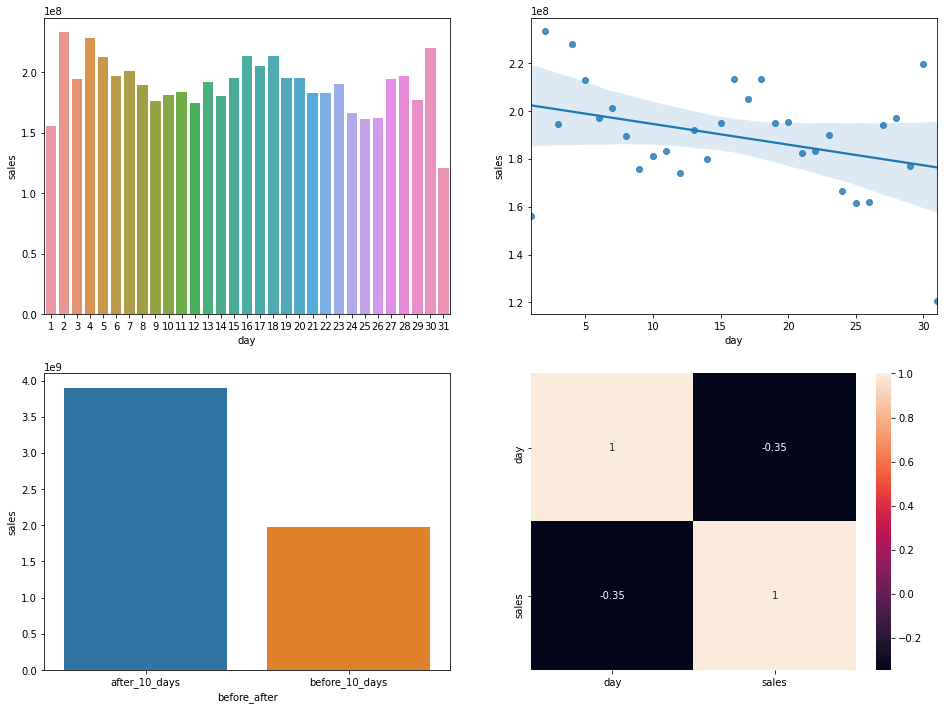

In [66]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1)
sb.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2)
sb.regplot( x='day', y='sales', data=aux1 );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 3)
sb.barplot( x='before_after', y='sales', data=aux2 );

plt.subplot( 2, 2, 4)
sb.heatmap( aux1[['day','sales']].corr( method='pearson' ), annot=True );

### **H21.** Lojas deveriam vender menos durante os feriados escolares.

**Verdadeiro.** Analisando os gráficos abaixo, percebe-se que as lojas vendem menos durante os feriados escolares, exceto no mês de Agosto, onde as vendas ultrapassaram as do período normal. Também é possível analisar que nos meses de Julho e Agosto houve um aumento repentino das vendas, uma teoria por trás dessa descoberta pode ser que nestes meses os alunos estão de férias escolares, passando muito mais tempo fora da escola, consequentemente abrindo mais oportunidades para comprarem nas lojas.

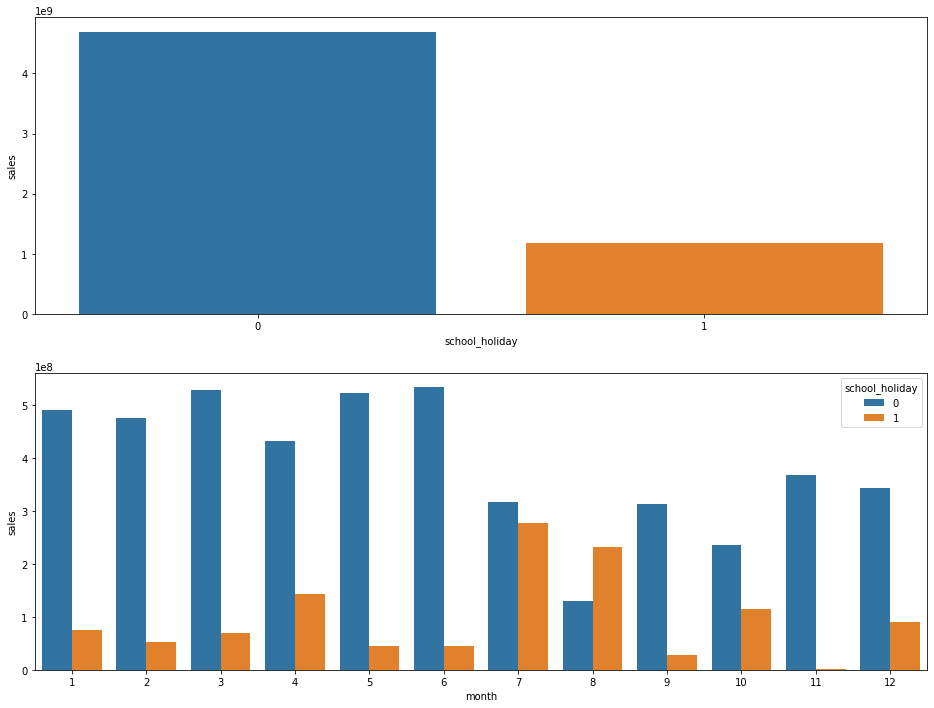

In [67]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sb.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot(2, 1, 2)
aux2 = df4[['month','school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
sb.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.1. Hypothesis Resume

In [68]:
tab = [ ['Hipoteses', 'Conclusao', 'Relevancia' ],
        ['H5', 'Falso', 'Baixa'],
        ['H6', 'Falso', 'Media'],
        ['H7', 'Falso', 'Media'],
        ['H13', 'Falso', 'Baixa'],
        ['H14', '-', '-'],
        ['H15', 'Falso', 'Baixa'],
        ['H16', 'Falso', 'Media'],
        ['H17', 'Verdadeira', 'Alta'],
        ['H18', 'Falso', 'Alta'],
        ['H19', 'Falso', 'Alta'],
        ['H20', 'Verdadeira', 'Alta'],
        ['H21', 'Verdadeira', 'Baixa'],
      ]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H5           Falso        Baixa
H6           Falso        Media
H7           Falso        Media
H13          Falso        Baixa
H14          -            -
H15          Falso        Baixa
H16          Falso        Media
H17          Verdadeira   Alta
H18          Falso        Alta
H19          Falso        Alta
H20          Verdadeira   Alta
H21          Verdadeira   Baixa


## 4.3. Multivariate Analysis

### 4.3.1. Numercial Attributes

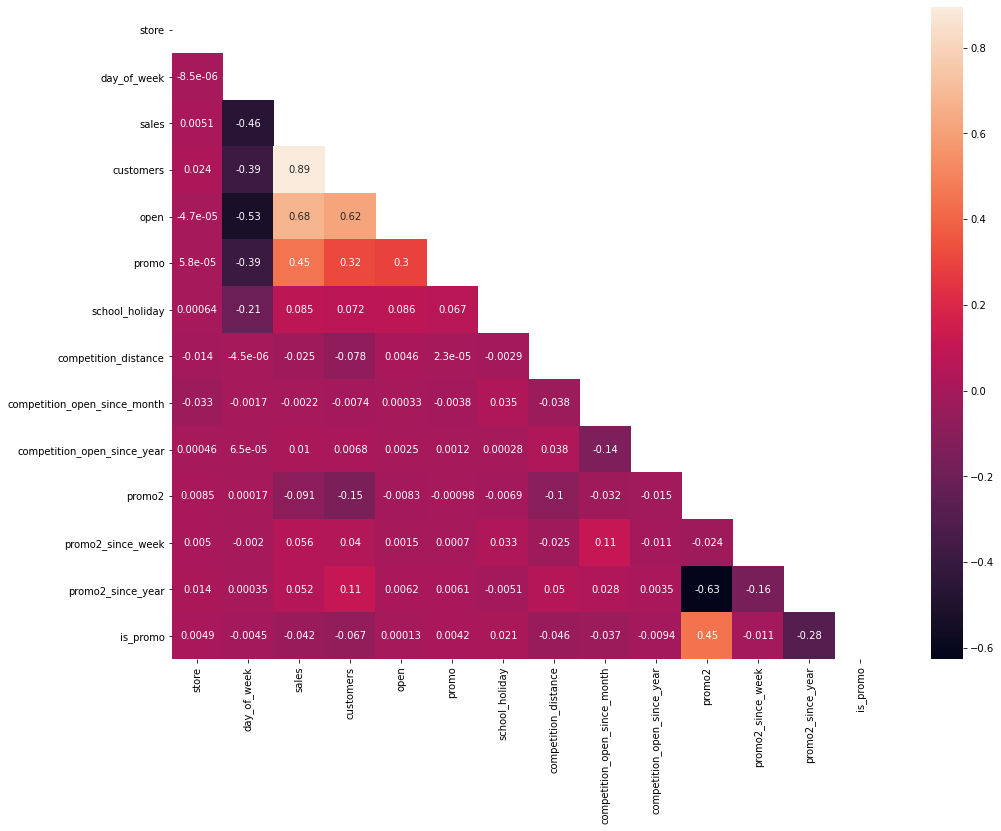

In [69]:
correlation = num_attributes.corr( method='pearson' )

# generate a mask for the upper triangle
mask = np.triu( np.ones_like(correlation, dtype=bool) )

sb.heatmap( correlation, annot=True, mask=mask );

### 4.3.2. Categorical Attributes

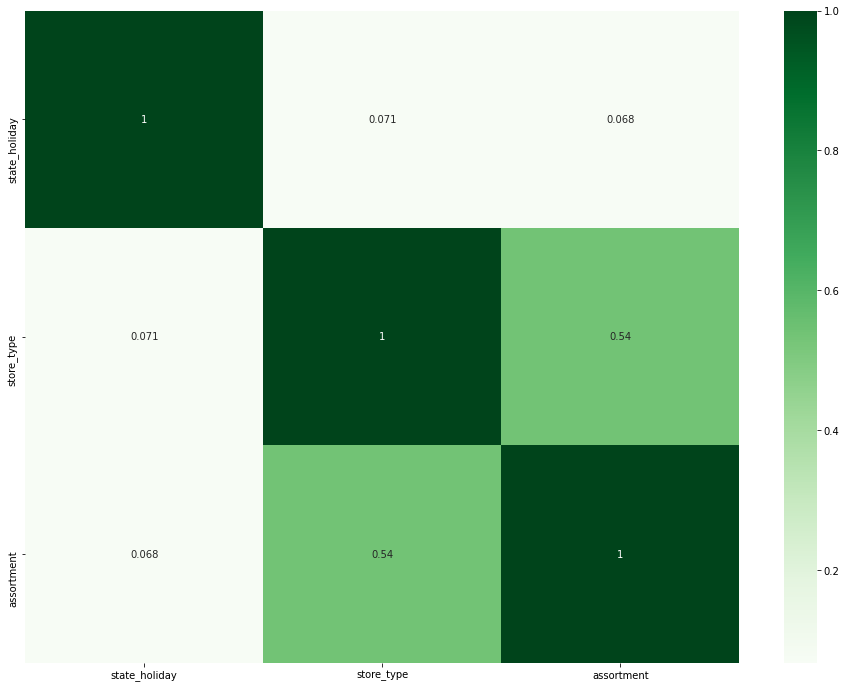

In [70]:
# only categorical data
new_catg = df4.select_dtypes( include='object' )

# calculate cramer V
catg1 = cramer_v(new_catg['state_holiday'], new_catg['state_holiday'])
catg2 = cramer_v(new_catg['state_holiday'], new_catg['store_type'])
catg3 = cramer_v(new_catg['state_holiday'], new_catg['assortment'])

catg4 = cramer_v(new_catg['store_type'], new_catg['state_holiday'])
catg5 = cramer_v(new_catg['store_type'], new_catg['store_type'])
catg6 = cramer_v(new_catg['store_type'], new_catg['assortment'])

catg7 = cramer_v(new_catg['assortment'], new_catg['state_holiday'])
catg8 = cramer_v(new_catg['assortment'], new_catg['store_type'])
catg9 = cramer_v(new_catg['assortment'], new_catg['assortment'])

# cramer's V resume
catg_resume = pd.DataFrame( {
                                'state_holiday': [catg1, catg2, catg3],
                                'store_type': [catg4, catg5, catg6],
                                'assortment': [catg7, catg8, catg9],              
                            })

catg_resume = catg_resume.set_index( catg_resume.columns )
sb.heatmap( catg_resume, annot=True, cmap='Greens' );

# 5.0. DATA PREPARATION

In [71]:
df5 = df4.copy()

## 5.1. Normalization

Analisando os gráficos das features numéricas na seção **4.1.2. Numerical Variable** percebeu-se que os dados que estamos trabalhando não possuem uma distribuição normal. Portanto, não será aplicado a normalização destes dados. Este passo seria utilizado se alguma feature apresentasse um padrão de distribuição normal, o que não é o caso.

## 5.2. Rescaling

Para identificar qual método de transformação utilizar, plotou-se o boxplot das variáveis abaixo para verificar qual será o melhor método de transformação utilizar. Analisando os gráficos abaixo percebeu-se que para features **competition_distance** e **competition_time_month** o método mais indicado será o Robust Scaler, devido ao seu alto número de outliers, já as features **year** e **promo_time_week** o método de transformação será o Min Max Scaler, por não possuírem tantos outliers.

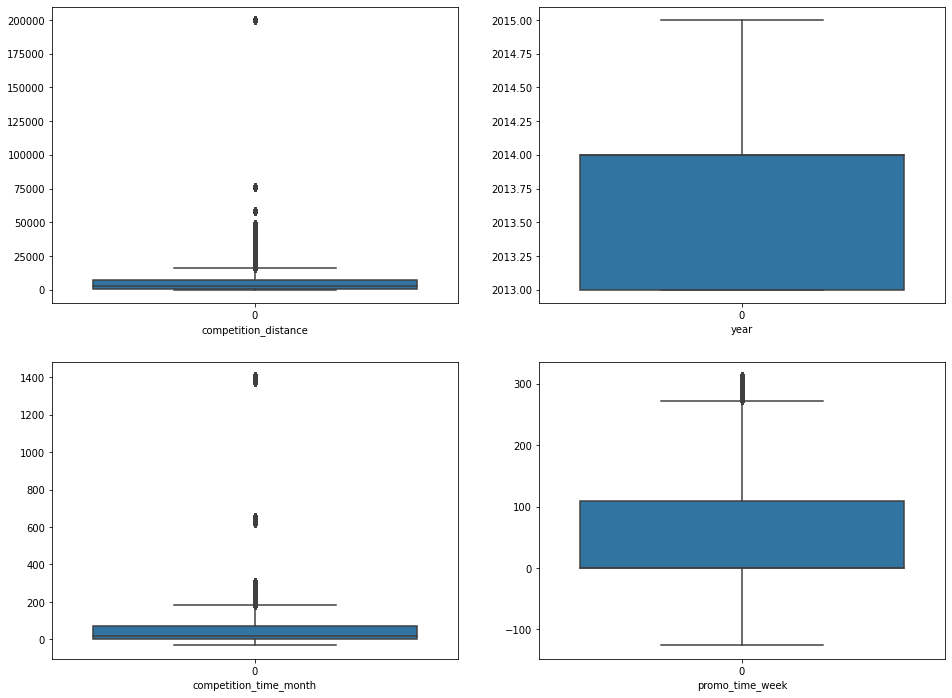

In [72]:
plt.subplot(2, 2, 1)
sb.boxplot( data=df5['competition_distance'] );
plt.xlabel('competition_distance');

plt.subplot(2, 2, 2)
sb.boxplot( data=df5['year'] );
plt.xlabel('year');

plt.subplot(2, 2, 3)
sb.boxplot( data=df5['competition_time_month'] );
plt.xlabel('competition_time_month');

plt.subplot(2, 2, 4)
sb.boxplot( data=df5['promo_time_week'] );
plt.xlabel('promo_time_week');

In [73]:
# applying transformations
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

## 5.3. Transformation

### 5.3.1. Encoding

Nesta etapa irei utilizar alguns métodos comumente usados para realização de encoding de variáveis categóricas. Como estamos no primeiro ciclo do CRISP, utilizarei os enconding de acordo com o *feeling da variável*, ou seja, aplicar transformações que fazem sentido para cada feature. Lembrando que nada impede de utilizar o mesmo tipo de encoding para todas variáveis, o que pode ser revisado no segundo ciclo.

In [74]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

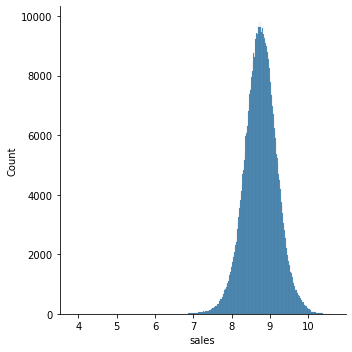

In [75]:
df5['sales'] = np.log1p( df5['sales'] )
sb.displot( df5['sales'] );

### 5.3.3. Nature Transformation

Este passo é muito importante para manter a natureza cíclica dos perídos dos anos, como, dia, mês, dia da semana, semana do ano, etc. Por mais que este passo resulta em adicionar mais colunas no dataset, consequentemente aumentando sua dimensionalidade, isto gera um ganho no momento de treinamento do algoritmo de machine learning, que conseguirá entender este fenômeno com muito mais clareza e precisão.

In [76]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi /7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi /7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi /12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi /12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi /30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi /30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi /52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi /52 ) ) )

# 6.0. FEATURE SELECTION

In [77]:
df6 = df5.copy()

## 6.1. Split Data Frame Into Training and Test

In [78]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

Identificando as datas de treino e teste. Na qual, as últimas 6 semanas serão os dados de teste e os dados de treinamento serão todo o conjunto de dados até a data limite descoberta pelo código abaixo.

In [79]:
df6[['date', 'store']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [80]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training min date: {}'.format( X_train['date'].min() ) )
print('Training max date: {}'.format( X_train['date'].max() ) )

print('\nTest min date: {}'.format( X_test['date'].min() ) )
print('Test max date: {}'.format( X_test['date'].max() ) )

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

Os snippets estão comentados, pois o seu objetivo principal é de conseguir identificar quais são as features mais relevantes para o modelo de Machine Learning. Como o Boruta é um algoritmo que demanda um longo tempo de processamento, foi criado uma seção **6.3. Manual Features Selection** que armazena todas as variáveis que este algoritmo selecionou como sendo importantes para o modelo.

In [81]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )

## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=9 ).fit( X_train_n, y_train_n )

### 6.2.1 Best Feature from Boruta

In [82]:
#cols_selected = boruta.support_.tolist()

## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.ilocs[:, cols_selected].columns.to_list()

## columns not selected by boruta
#cols_not_selected_boruta = list ( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Manual Features Selection

In [83]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [135]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series data preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [90]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [91]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [138]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model

In [92]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression Regularized - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Cross Validation

In [139]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Average and Linear Models Resume

Analisando a performance dos modelos de comportamento linear, percebeu-se que estes obtiveram um desempenho pior do que um modelo simples de média (**Average Model**). Analisando este fato, nos da a confirmação de que o fenômeno que o modelo está tentando aprender possui um comportamento não linear. Portanto, no próximo passo será utilizado algoritmos não lineares para que o modelo consiga aprender e melhorar o seu desempenho.

## 7.4. Random Forest Regressor

In [93]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=9 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.894635,0.101039,1024.295227


### 7.4.1 Random Forest Regressor - Cross Validation

In [140]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.6 +/- 216.27,0.12 +/- 0.02,1256.95 +/- 317.35


## 7.5. XGBoost Regressor

In [94]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=100, eta=0.01, 
                             max_depth=10, subsample=0.7, colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [141]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Models Performance

### 7.6.1 Single Performance

In [142]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,686.894635,0.101039,1024.295227
0,XGBoost Regressor,843.112293,0.122609,1250.952637
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression Regularized - Lasso,1891.704881,0.289106,2744.451737
0,Linear Regression,1980.039151,0.283893,2840.000319


### 7.6.2 Real Performance - Cross Validation

In [144]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE CV' )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.6 +/- 216.27,0.12 +/- 0.02,1256.95 +/- 317.35
0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


Analisando a performance dos algoritmos não lineares, percebeu-se que os 2 algoritmos que apresentaram melhor resultado foram **Random Forest Regressor** e **XGBoost Regressor**, ambos apresentaram um RMSE (*Root Mean Squared Error*) bem parecidos e muito menor que os algoritmos lineares, logo, cabe a mim como um cientista de dados escolher qual modelo será usado em produção. Analisando a questão do tempo em que o **Random Forest Regressor** levou para ser treinado, e o possível custo financeiro que este algoritmo pode trazer para ser implementado, tendo em vista que a diferença entre ele e o **XGBoost Regressor** não é tão considerável em relação aos outros modelos, decidi escolher o **XGBoost** como o algoritmo ideal para colocar o modelo em produção e fazer o ajuste de parâmetros necessários para melhorar sua performance. 

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [153]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [155]:
#final_result = pd.DataFrame()

#for i in range( MAX_EVAL ):
#  # choose values for parameters randomly
#  hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
# print( hp )

#  # model
#  model_xgb = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=hp['n_estimators'], eta=hp['eta'], 
#                              max_depth=hp['max_depth'], subsample=hp['subsample'], colsample_bytee=hp['colsample_bytee'], min_child_weight=hp['min_child_weight'] ).fit( x_train, y_train )

#  # prediction
#  yhat_xgb = model_xgb.predict( x_test )

#  # performance
#  result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb )
#  final_result = pd.concat( [final_result, result] )

#final_result.sort_values( 'RMSE CV' )

## 8.2. Final Model

In [156]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytee': 0.7,
    'min_child_weight': 3 
}

In [157]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', n_estimators=param_tuned['n_estimators'], eta=param_tuned['eta'], max_depth=param_tuned['max_depth'], 
                             subsample=param_tuned['subsample'], colsample_bytee=param_tuned['colsample_bytee'], min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,664.974997,0.097529,957.774225


In [160]:
# saving trained model
pickle.dump(  model_xgb_tuned, open( '/content/drive/MyDrive/Colab Notebooks/Rossman Sales Prediction/model/rossman_xgb_model.pkl', 'wb' ) )

# 9.0. ERROR INTERPRETATION AND TRANSLATION

In [161]:
df9 = X_test[ cols_selected_boruta_full ]

# rescaling
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 9.1. Business Performance

In [169]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [171]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
692,693,240813.328125,240024.588907,241602.067343,788.739218,0.109933
827,828,207616.781250,207003.645871,208229.916629,613.135379,0.148970
848,849,293714.906250,293029.611223,294400.201277,685.295027,0.079117
442,443,196065.375000,195609.338445,196521.411555,456.036555,0.092361
668,669,188986.671875,188498.994642,189474.349108,487.677233,0.095376


Para identificar quais são as lojas que possuem maior dificuldade em conseguir uma previsão de vendas adequada, faz-se uma ordenação pelo **MAPE** (*Mean Absolute Percentage Error*) que indica qual é a variação em termos da porcentagem do **MAE** (*Mean Absolute Error*). Analisando a tabela abaixo, percebe-se que a **store: 292** possui um MAPE de 56%, ou seja, o valor predito em média pode estar 56% para cima ou para baixo (superestimando ou subestimando).

In [172]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,100714.981535,107351.190340,3318.104402,0.565828
908,909,238233.875000,230573.337254,245894.412746,7660.537746,0.520433
875,876,203030.156250,199110.952414,206949.360086,3919.203836,0.305099
721,722,353005.781250,351013.625119,354997.937381,1992.156131,0.268338
594,595,400883.625000,397415.263170,404351.986830,3468.361830,0.242192


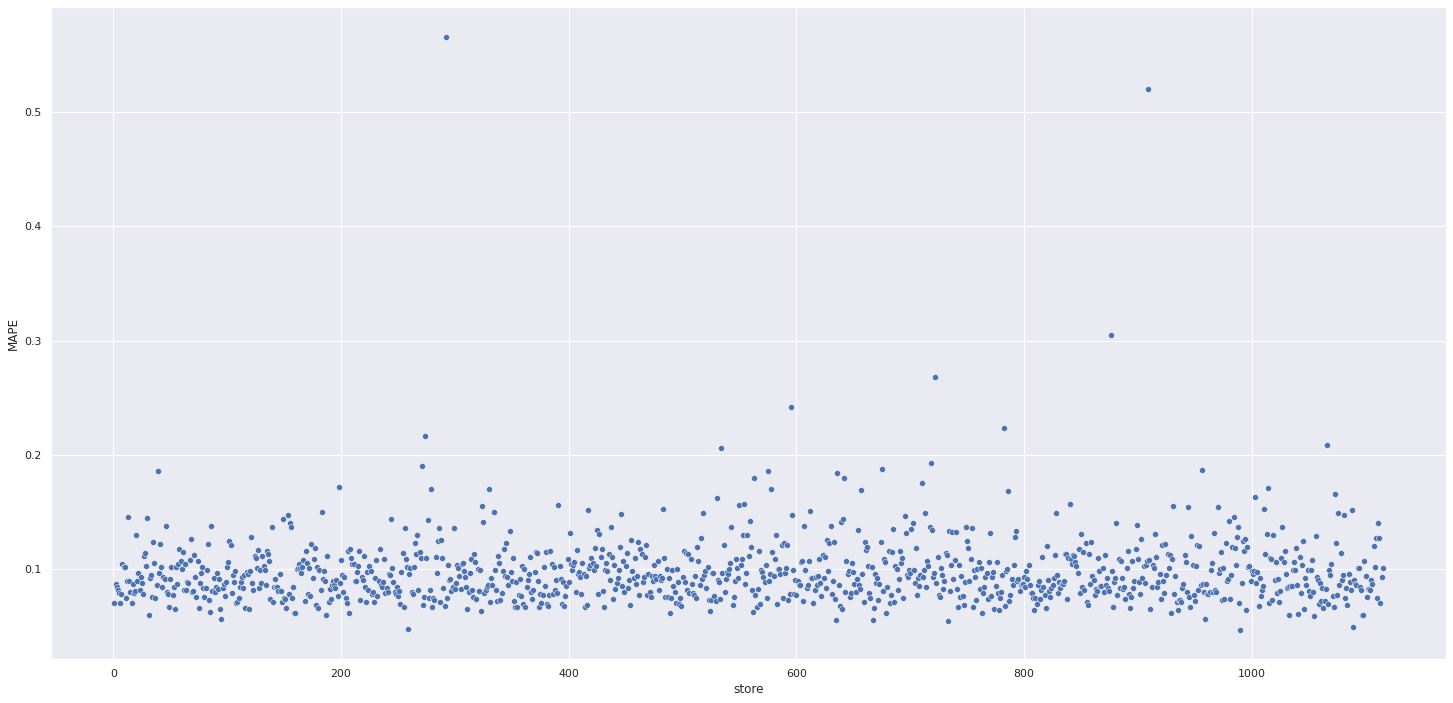

In [192]:
sb.scatterplot( x='store', y='MAPE', data=df92 );

## 9.2. Total Performance

A tabela abaixo, mostra para o CFO (*stakeholder*) qual é o risco e a previsão das lojas da Rossmann. É notável que a diferença entre o melhor cenário e o pior cenário não é muito elevada, aproximadamente **1.5 milhões** , tendo em vista que em média, os valores do melhor e pior cenário estão na faixa de **285.9 milhões**.

In [186]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'scenario', 0: 'values'} )
df93['values'] = df93['values'].map( '${:,.2f}'.format )
df93

,scenario,values
0,predictions,"$285,860,480.00"
1,worst_scenario,"$285,115,015.78"
2,best_scenario,"$286,605,979.91"


## 9.3. Machine Learning Performance

In [180]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


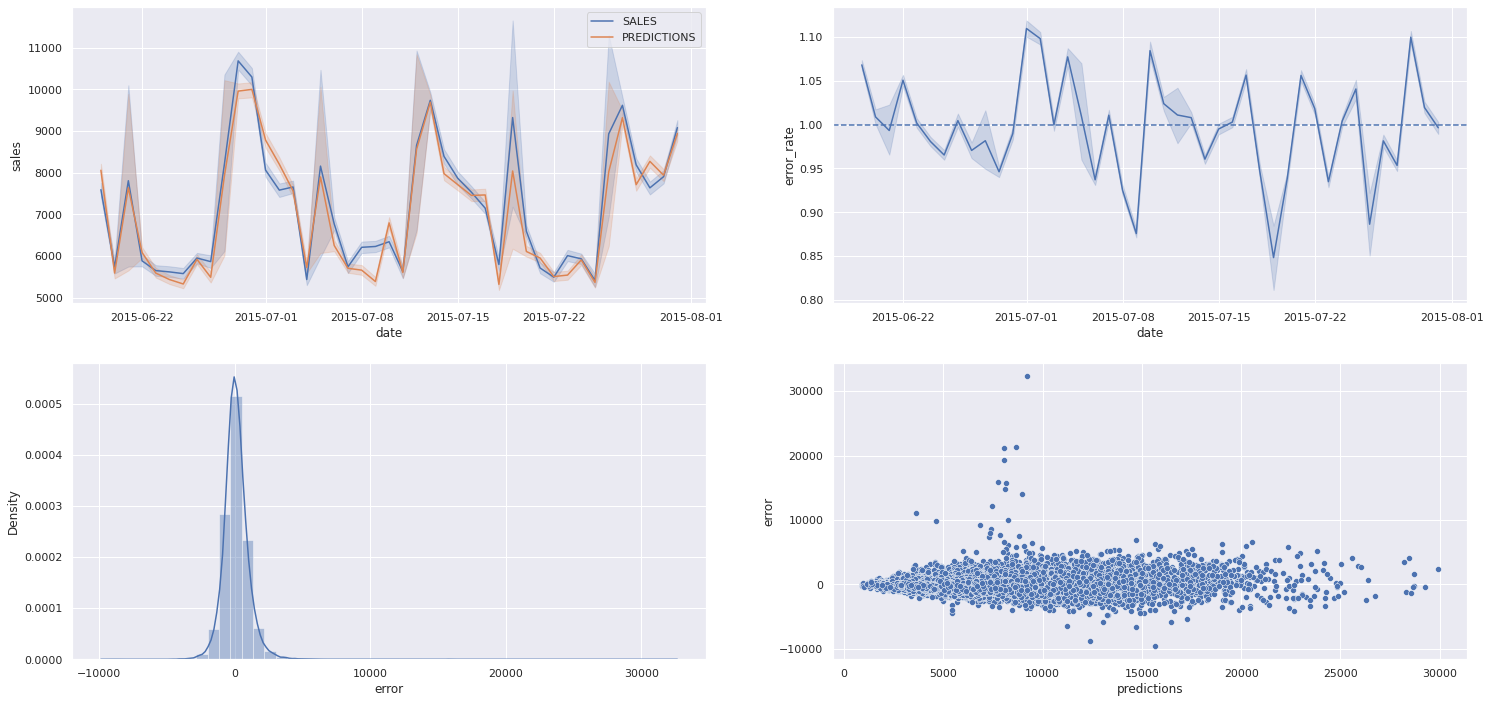

In [191]:
plt.subplot( 2, 2, 1 )
sb.lineplot( x='date', y='sales', data=df9, label='SALES');
sb.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot( 2, 2, 2 )
sb.lineplot( x='date', y='error_rate', data=df9);
plt.axhline( 1, linestyle='--' );

plt.subplot( 2, 2, 3)
sb.distplot( df9['error'] );

plt.subplot( 2, 2, 4)
sb.scatterplot( df9['predictions'], df9['error'] );

Analisando os gráficos acima que visam mostrar como está a performance do modelo de machine learning treinado nesta etapa do projeto, percebe-se que a **XGBoost** apresentou ótimos resultados de performance já no primeiro ciclo do CRISP, na qual, notou-se uma boa aproximação dos valores reais de venda. Apesar de ainda estar na primeira etapa do ciclo, este modelo já pode ser utilizado como solução para o problema de previsão de vendas, tendo em vista, que o mesmo já é capaz de prever as vendas da maiorias das lojas com bastante precisão.